In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import os

In [2]:
df = pd.read_csv('gemini_output.csv', delimiter=',', error_bad_lines=False, warn_bad_lines=True)
df['Analysis Result'] = df['Analysis Result'].str.extract(r'\[(.*)\]')

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_12780\2971901269.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('gemini_output.csv', delimiter=',', error_bad_lines=False, warn_bad_lines=True)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_12780\2971901269.py:1: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('gemini_output.csv', delimiter=',', error_bad_lines=False, warn_bad_lines=True)
Skipping line 22559: expected 2 fields, saw 9



In [3]:
df.head()

,Image Name,Analysis Result
0,roi_0_0.jpeg,"""Sky"", ""Road"", ""Soil"", ""Tree"", ""Vegetation"", ""..."
1,roi_10006_0.jpeg,"""House"", ""Building"", ""Car"", ""Vehicle"", ""Road"",..."
2,roi_10009_0.jpeg,"""Vegetation"", ""Wall"", ""Soil"", ""Bush"""
3,roi_10009_1.jpeg,"""Sky"""
4,roi_10009_2.jpeg,"""Sky"""


In [4]:
# Convert all values in the column to strings, then split
df['Analysis Result'] = df['Analysis Result'].apply(
    lambda x: [item.replace('"', '').replace("'", "") for item in str(x).split(',')] if isinstance(x, str) else []
)

# Display the updated DataFrame
print(df.head())


         Image Name                                    Analysis Result
0      roi_0_0.jpeg  [Sky,  Road,  Soil,  Tree,  Vegetation,  Mount...
1  roi_10006_0.jpeg  [House,  Building,  Car,  Vehicle,  Road,  Tre...
2  roi_10009_0.jpeg                  [Vegetation,  Wall,  Soil,  Bush]
3  roi_10009_1.jpeg                                              [Sky]
4  roi_10009_2.jpeg                                              [Sky]


In [5]:
# Extract the first number after "roi_" in the "Image Name" column
df['image_name'] = df['Image Name'].str.extract(r'roi_(\d+)_')

# Remove rows where 'First Number' is NaN
df = df.dropna(subset=['image_name'])

# Optionally, convert the column to integer after removing NaN rows
df['image_name'] = df['image_name'].astype(str)

# Add .png to the 'image_name' column
df['image_name'] = df['image_name'].apply(lambda x: f"{x}.png")

# Display the updated DataFrame
print(df.head())


         Image Name                                    Analysis Result  \
0      roi_0_0.jpeg  [Sky,  Road,  Soil,  Tree,  Vegetation,  Mount...   
1  roi_10006_0.jpeg  [House,  Building,  Car,  Vehicle,  Road,  Tre...   
2  roi_10009_0.jpeg                  [Vegetation,  Wall,  Soil,  Bush]   
3  roi_10009_1.jpeg                                              [Sky]   
4  roi_10009_2.jpeg                                              [Sky]   

  image_name  
0      0.png  
1  10006.png  
2  10009.png  
3  10009.png  
4  10009.png  


In [6]:
# Group by 'First Number' and combine lists in 'Analysis Result'
df_combined = df.groupby('image_name', as_index=False).agg({
    'Analysis Result': 'sum'  # Combine lists by summing them
})

# Display the resulting DataFrame
print(df_combined.head())


  image_name                                    Analysis Result
0      0.png  [Sky,  Road,  Soil,  Tree,  Vegetation,  Mount...
1      1.png  [Sky,  Tree,  Vegetation,  Bush, Sky,  Tree,  ...
2  10006.png  [House,  Building,  Car,  Vehicle,  Road,  Tre...
3  10009.png  [Vegetation,  Wall,  Soil,  Bush, Sky, Sky, Sk...
4  10011.png  [Sky,  Tree,  Vegetation,  Building,  House,  ...


In [7]:
# Flatten all lists in the "Analysis Result" column into a single list
# and standardize to lowercase
all_values = [
    item.strip().lower() for sublist in df_combined['Analysis Result'] if isinstance(sublist, list) for item in sublist
]

# Count the occurrences of each value
value_counts = Counter(all_values)

# Convert the counts to a DataFrame for better visualization
counts_df = pd.DataFrame(value_counts.items(), columns=['Object', 'Count']).sort_values(by='Count', ascending=False)

# Display the counts
print(counts_df)

         Object  Count
4    vegetation  15543
0           sky   7817
2          soil   7172
17      nothing   6831
7          bush   6732
..          ...    ...
98                   2
97     ski lift      2
96        slide      2
93       pigeon      2
154    contrail      2

[155 rows x 2 columns]


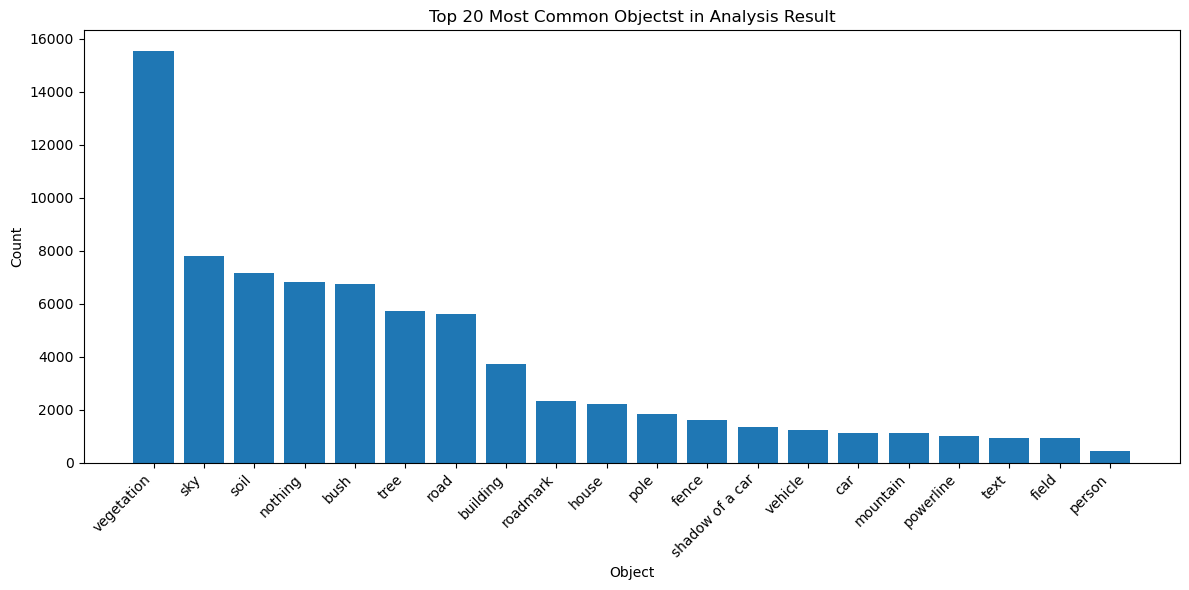

In [8]:
# Plot the top 20 most common values
top_n = 20
top_counts = counts_df.head(top_n)

# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(top_counts['Object'], top_counts['Count'])
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.xlabel('Object')
plt.ylabel('Count')
plt.title('Top 20 Most Common Objectst in Analysis Result')
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


In [9]:
test_predictions_path = 'models/ResNet50/test_predictions.csv'
df_test_predictions = pd.read_csv(test_predictions_path)

# Merge the two datasets on the 'image_name' column
merged_df = pd.merge(df_combined, df_test_predictions[['image_name', 'sub-region', 'model_prediction']], on='image_name', how='left')

# Display the merged DataFrame
print(merged_df.head())

  image_name                                    Analysis Result  \
0      0.png  [Sky,  Road,  Soil,  Tree,  Vegetation,  Mount...   
1      1.png  [Sky,  Tree,  Vegetation,  Bush, Sky,  Tree,  ...   
2  10006.png  [House,  Building,  Car,  Vehicle,  Road,  Tre...   
3  10009.png  [Vegetation,  Wall,  Soil,  Bush, Sky, Sky, Sk...   
4  10011.png  [Sky,  Tree,  Vegetation,  Building,  House,  ...   

        sub-region  model_prediction  
0              NaN               NaN  
1              NaN               NaN  
2  Southern Europe  Northern America  
3  Southern Europe   Southern Europe  
4  Southern Europe  Northern America  


In [10]:
# Create a new column 'is_correct' to indicate if the prediction matches the sub-region
merged_df['is_correct'] = merged_df['model_prediction'] == merged_df['sub-region']

# Display the updated DataFrame
print(merged_df.head())


  image_name                                    Analysis Result  \
0      0.png  [Sky,  Road,  Soil,  Tree,  Vegetation,  Mount...   
1      1.png  [Sky,  Tree,  Vegetation,  Bush, Sky,  Tree,  ...   
2  10006.png  [House,  Building,  Car,  Vehicle,  Road,  Tre...   
3  10009.png  [Vegetation,  Wall,  Soil,  Bush, Sky, Sky, Sk...   
4  10011.png  [Sky,  Tree,  Vegetation,  Building,  House,  ...   

        sub-region  model_prediction  is_correct  
0              NaN               NaN       False  
1              NaN               NaN       False  
2  Southern Europe  Northern America       False  
3  Southern Europe   Southern Europe        True  
4  Southern Europe  Northern America       False  


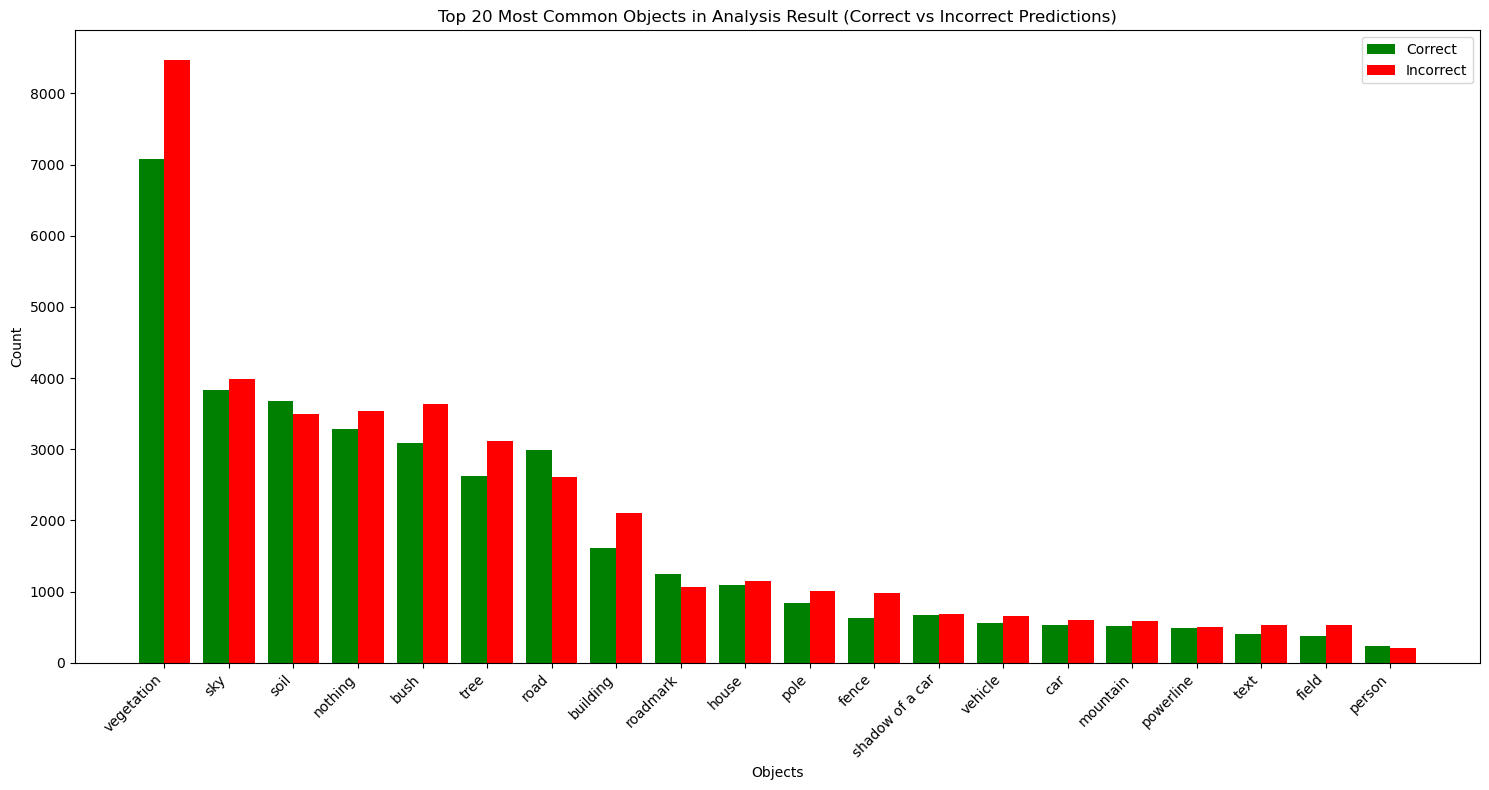

In [11]:
# Flatten all lists in the "Analysis Result" column into a single list, standardizing to lowercase
all_values_correct = [
    item.strip().lower()
    for sublist in merged_df[merged_df['is_correct']]['Analysis Result']
    if isinstance(sublist, list)
    for item in sublist
]
all_values_incorrect = [
    item.strip().lower()
    for sublist in merged_df[~merged_df['is_correct']]['Analysis Result']
    if isinstance(sublist, list)
    for item in sublist
]

# Count the occurrences of each value
correct_counts = Counter(all_values_correct)
incorrect_counts = Counter(all_values_incorrect)

# Combine counts into a DataFrame for visualization
objects = list(set(correct_counts.keys()).union(set(incorrect_counts.keys())))
data = {
    'Object': objects,
    'Correct': [correct_counts.get(obj, 0) for obj in objects],
    'Incorrect': [incorrect_counts.get(obj, 0) for obj in objects],
}
plot_df = pd.DataFrame(data)

# Sort by total count and keep the top 20 objects
plot_df['Total'] = plot_df['Correct'] + plot_df['Incorrect']
plot_df = plot_df.sort_values(by='Total', ascending=False).head(20)

# Plot a side-by-side bar chart
plt.figure(figsize=(15, 8))
bar_width = 0.4
x = range(len(plot_df))

# Plot bars for correct and incorrect counts side by side
plt.bar([p - bar_width / 2 for p in x], plot_df['Correct'], width=bar_width, label='Correct', color='green')
plt.bar([p + bar_width / 2 for p in x], plot_df['Incorrect'], width=bar_width, label='Incorrect', color='red')

# Add labels and legend
plt.xlabel('Objects')
plt.ylabel('Count')
plt.title('Top 20 Most Common Objects in Analysis Result (Correct vs Incorrect Predictions)')
plt.xticks(x, plot_df['Object'], rotation=45, ha='right')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [12]:
# Explode the "Analysis Result" column to create one row per object
df_exploded = merged_df.explode('Analysis Result')

# Convert objects to lowercase for consistency
df_exploded['Analysis Result'] = df_exploded['Analysis Result'].str.strip().str.lower()

# Group by each unique object in the "Analysis Result" column and calculate statistics
object_stats = df_exploded.groupby('Analysis Result')['is_correct'].agg(
    total_occurrences='count',
    correct_predictions='sum',
    incorrect_predictions=lambda x: x.count() - x.sum()
).reset_index()

# Calculate the accuracy percentage for each object
object_stats['accuracy'] = (object_stats['correct_predictions'] / object_stats['total_occurrences']) * 100

# Sort by accuracy or total occurrences for analysis
object_stats = object_stats.sort_values(by='accuracy', ascending=False)

# Display the statistics
object_stats

,Analysis Result,total_occurrences,correct_predictions,incorrect_predictions,accuracy
0,,2,2,0,100.0
33,chimney,4,4,0,100.0
45,drain,2,2,0,100.0
49,fire hydrant,2,2,0,100.0
54,food,2,2,0,100.0
...,...,...,...,...,...
75,light fixture,2,0,2,0.0
72,ladder,2,0,2,0.0
71,ice,2,0,2,0.0
70,hydrant,2,0,2,0.0


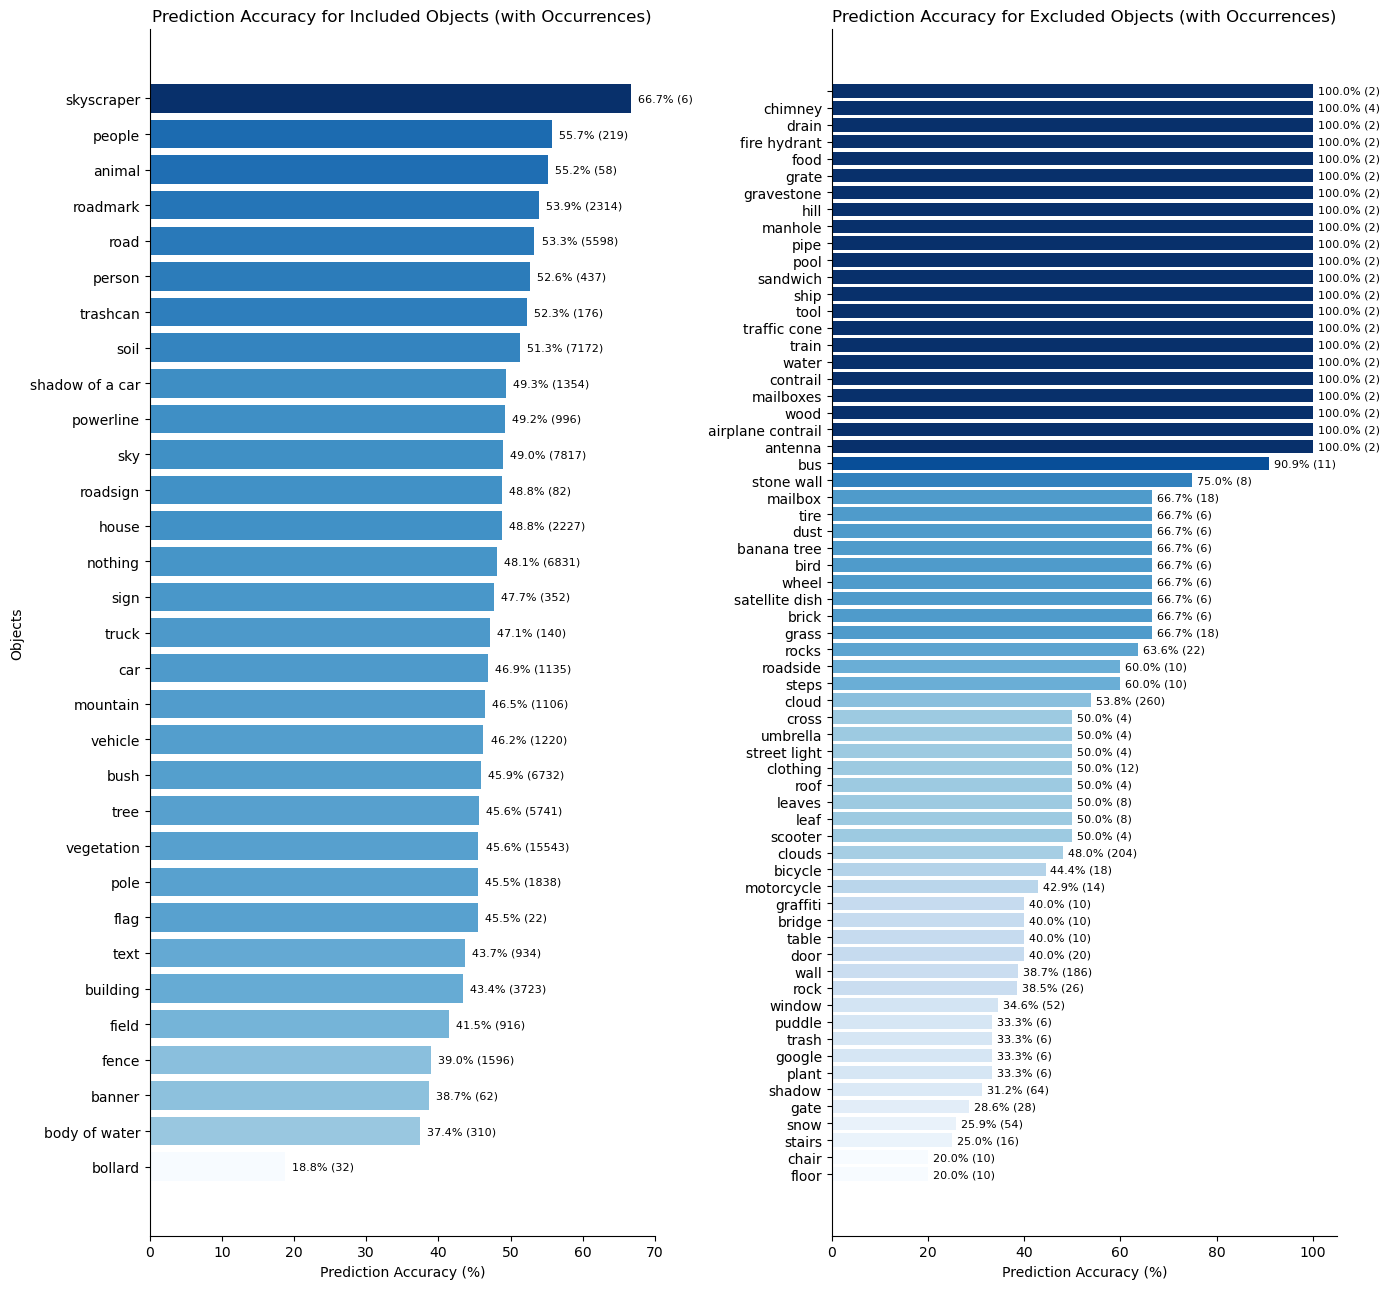

In [13]:
# Define the objects to include (those in the specified list)
objects_to_include = [
    "sky", "road", "roadmark", "soil", "building", "house", "pole", "tree",
    "trashcan", "shadow of a car", "car", "vehicle", "truck", "powerline", "sign", "banner",
    "roadsign", "fence", "bollard", "person", "text", "skyscraper", "mountain", "body of water",
    "nothing", "bush", "vegetation", 'people', "field", "flag", "animal"
]

# Remove quotes from the 'Analysis Result' column in the final_metrics_df
object_stats['Analysis Result'] = object_stats['Analysis Result'].str.replace('"', '')

# Filter object_stats to only include the specified objects in lowercase (for the included graph)
top_objects_filtered_included = object_stats[object_stats['Analysis Result'].str.lower().isin(objects_to_include)]

# Filter object_stats to exclude the specified objects in lowercase (for the excluded graph)
top_objects_filtered_excluded = object_stats[~object_stats['Analysis Result'].str.lower().isin(objects_to_include)]

# Remove objects with 0 accuracy from both DataFrames
top_objects_filtered_included = top_objects_filtered_included[top_objects_filtered_included['accuracy'] > 0]
top_objects_filtered_excluded = top_objects_filtered_excluded[top_objects_filtered_excluded['accuracy'] > 0]

# Create a color map based on accuracy values (higher accuracy = darker blue)
norm_included = plt.Normalize(vmin=top_objects_filtered_included['accuracy'].min(), vmax=top_objects_filtered_included['accuracy'].max())
norm_excluded = plt.Normalize(vmin=top_objects_filtered_excluded['accuracy'].min(), vmax=top_objects_filtered_excluded['accuracy'].max())

cmap = plt.cm.Blues  # Color map (you can choose others like 'viridis', 'plasma', etc.)
colors_included = [cmap(norm_included(acc)) for acc in top_objects_filtered_included['accuracy']]
colors_excluded = [cmap(norm_excluded(acc)) for acc in top_objects_filtered_excluded['accuracy']]

# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 13))  # Create a 1x2 grid of subplots

# Plot the first chart (left side) for included objects
bars1 = axes[0].barh(top_objects_filtered_included['Analysis Result'], top_objects_filtered_included['accuracy'], color=colors_included)

# Add text for accuracy and occurrences next to each bar (left side)
for bar, total, accuracy in zip(bars1, top_objects_filtered_included['total_occurrences'], top_objects_filtered_included['accuracy']):
    axes[0].text(
        bar.get_width() + 1,  # Position to the right of the bar
        bar.get_y() + bar.get_height() / 2,  # Vertically centered
        f'{accuracy:.1f}% ({total})',  # Display accuracy and occurrences
        ha='left', va='center', fontsize=8  # Reduce font size for clarity
    )

# Customize the first plot (left side)
axes[0].set_xlabel('Prediction Accuracy (%)')
axes[0].set_ylabel('Objects')
axes[0].set_title('Prediction Accuracy for Included Objects (with Occurrences)')
axes[0].invert_yaxis()  # Invert y-axis for better readability

# Remove the right and top spines (left side)
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)

# Plot the second chart (right side) for excluded objects
bars2 = axes[1].barh(top_objects_filtered_excluded['Analysis Result'], top_objects_filtered_excluded['accuracy'], color=colors_excluded)

# Add text for accuracy and occurrences next to each bar (right side)
for bar, total, accuracy in zip(bars2, top_objects_filtered_excluded['total_occurrences'], top_objects_filtered_excluded['accuracy']):
    axes[1].text(
        bar.get_width() + 1,  # Position to the right of the bar
        bar.get_y() + bar.get_height() / 2,  # Vertically centered
        f'{accuracy:.1f}% ({total})',  # Display accuracy and occurrences
        ha='left', va='center', fontsize=8  # Reduce font size for clarity
    )

# Customize the second plot (right side)
axes[1].set_xlabel('Prediction Accuracy (%)')
axes[1].set_title('Prediction Accuracy for Excluded Objects (with Occurrences)')
axes[1].invert_yaxis()  # Invert y-axis for better readability

# Remove the right and top spines (right side)
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [14]:
# Base directory containing the model folders
base_dir = 'models/'

# Initialize an empty list to store DataFrames
all_metrics = []

# Loop through each folder in the base directory
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    
    # Skip models named 'test' and 'test2'
    if folder.lower() in ['test', 'test_2']:
        continue
    
    # Check if it's a directory
    if os.path.isdir(folder_path):
        # Path to metrics.csv
        metrics_file = os.path.join(folder_path, 'metrics.csv')
        
        # Check if metrics.csv exists in the folder
        if os.path.exists(metrics_file):
            # Read the metrics.csv
            metrics_df = pd.read_csv(metrics_file)
            
            # Add a column for the model name
            metrics_df['model'] = folder
            
            # Append to the list of DataFrames
            all_metrics.append(metrics_df)

# Concatenate all DataFrames into a single DataFrame
final_metrics_df = pd.concat(all_metrics, ignore_index=True)

# Display the resulting DataFrame
final_metrics_df

# Optionally save the final DataFrame to a CSV
output_file = os.path.join(base_dir, 'compiled_metrics.csv')
final_metrics_df.to_csv(output_file, index=False)

print(f'The file can be found here: {output_file}')


The file can be found here: models/compiled_metrics.csv


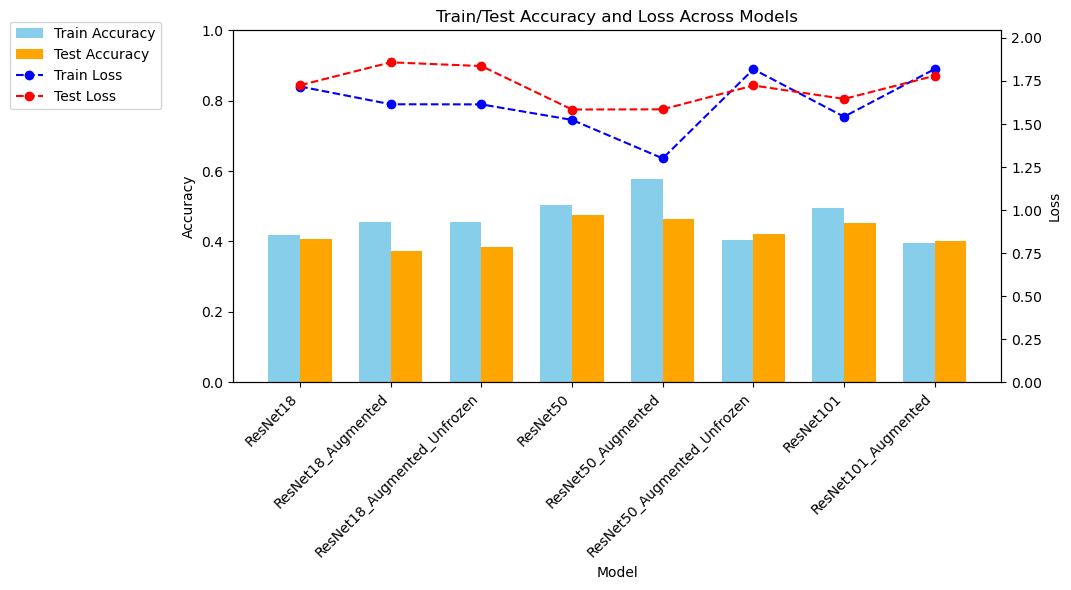

In [15]:
# Define the desired order of models
desired_order = [
    "ResNet18", 
    "ResNet18_Augmented", 
    "ResNet18_Augmented_Unfrozen", 
    "ResNet50", 
    "ResNet50_Augmented", 
    "ResNet50_Augmented_Unfrozen", 
    "ResNet101", 
    "ResNet101_Augmented"
]

# Set the categorical order and sort the DataFrame
final_metrics_df['model'] = pd.Categorical(final_metrics_df['model'], categories=desired_order, ordered=True)
final_metrics_df = final_metrics_df.sort_values('model')

# Set up the figure and axis
fig, ax1 = plt.subplots(figsize=(15, 6))

# Define bar positions and width
x = np.arange(len(final_metrics_df['model']))
width = 0.35

# Plot bar chart for accuracy
bar1 = ax1.bar(x - width / 2, final_metrics_df['train_accuracy'], width, label='Train Accuracy', color='skyblue')
bar2 = ax1.bar(x + width / 2, final_metrics_df['test_accuracy'], width, label='Test Accuracy', color='orange')

# Customize the primary y-axis (accuracy)
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)  # Assuming accuracy is between 0 and 1
ax1.set_xticks(x)
ax1.set_xticklabels(final_metrics_df['model'], rotation=45, ha='right')
ax1.set_xlabel('Model')

# Create a secondary y-axis for loss
ax2 = ax1.twinx()
line1, = ax2.plot(x, final_metrics_df['train_loss'], label='Train Loss', marker='o', color='blue', linestyle='--')
line2, = ax2.plot(x, final_metrics_df['test_loss'], label='Test Loss', marker='o', color='red', linestyle='--')

# Customize the secondary y-axis (loss)
ax2.set_ylabel('Loss')
ax2.set_ylim(0, max(final_metrics_df[['train_loss', 'test_loss']].max()) * 1.1)

# Add a title
plt.title('Train/Test Accuracy and Loss Across Models')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(
    lines + lines2, 
    labels + labels2, 
    loc='center left', 
    bbox_to_anchor=(-0.3, 0.9),
)

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0.2, 0, 1, 1])  # Adjust the figure to make room for the legend
plt.show()


In [16]:
import os
import pandas as pd
import numpy as np

# Path to the models folder
models_path = 'models'

# List of probability columns
prob_columns = [
    'prob_Northern America', 'prob_Eastern Asia', 'prob_Southern Europe',
    'prob_Latin America and the Caribbean', 'prob_Sub-Saharan Africa', 
    'prob_Western Asia', 'prob_Northern Europe', 'prob_Western Europe', 
    'prob_South-eastern Asia', 'prob_Eastern Europe', 'prob_Southern Asia', 'prob_nan'
]

# List of sub-regions
sub_regions = [
    'Northern America',
    'Eastern Asia',
    'Southern Europe',
    'Latin America and the Caribbean',
    'Sub-Saharan Africa',
    'Western Asia',
    'Northern Europe',
    'Western Europe',
    'South-eastern Asia',
    'Eastern Europe',
    'Southern Asia',
    'nan'
]

# Function to get the top N indices
def get_top_n_indices(values, n):
    arr = np.array(values)  # Convert list to numpy array for easier manipulation
    top_n_indices = arr.argsort()[-n:][::-1]  # Get indices of the n largest values in descending order
    return top_n_indices.tolist()  # Convert to list

# Function to map indices to sub-region names
def map_indices_to_sub_regions(indices):
    return [sub_regions[i] for i in indices]

# Number of top values to extract
n = 3

# Prepare a dictionary to store results
metrics = []

# Iterate through each subfolder in the models directory
for model_name in os.listdir(models_path):
    model_path = os.path.join(models_path, model_name)
    test_predictions_path = os.path.join(model_path, 'test_predictions.csv')
    
    # Check if test_predictions.csv exists in the folder
    if os.path.exists(test_predictions_path):
        try:
            # Read the test_predictions.csv file
            df2 = pd.read_csv(test_predictions_path)

            # Check if required columns exist
            missing_columns = [col for col in prob_columns if col not in df2.columns]
            if missing_columns:
                print(f"Skipping {model_name} due to missing columns: {missing_columns}")
                continue

            # Create the new DataFrame
            df_result = pd.DataFrame({
                'image_name': df2['image_name'],
                'sub_region': df2['sub-region'],
                'value_list': df2[prob_columns].values.tolist()
            })

            # Apply the function to calculate top N indices
            df_result['top_n_indices'] = df_result['value_list'].apply(lambda x: get_top_n_indices(x, n))

            # Map indices to sub-region names
            df_result['top_n_regions'] = df_result['top_n_indices'].apply(map_indices_to_sub_regions)

            # Check if the correct region is in the top N
            df_result['is_correct'] = df_result.apply(lambda row: row['sub_region'] in row['top_n_regions'], axis=1)

            # Calculate the metric: true / total
            true_count = df_result['is_correct'].sum()
            total_count = len(df_result)
            metric = true_count / total_count

            # Store the result
            metrics.append({'model': model_name, 'metric': metric})
        except Exception as e:
            print(f"Error processing {model_name}: {e}")
            continue

# Convert results to a DataFrame and display
metrics_df = pd.DataFrame(metrics)

metrics_df

Skipping test due to missing columns: ['prob_nan']


,model,metric
0,ResNet101,0.701531
1,ResNet101_Augmented,0.661364
2,ResNet18,0.663154
3,ResNet18_Augmented,0.629747
4,ResNet18_Augmented_Unfrozen,0.635713
5,ResNet50,0.729966
6,ResNet50_Augmented,0.709883
7,ResNet50_Augmented_Unfrozen,0.671505
8,test_2,0.667528
